# CNN Model to predict seamounts 

Test of keras tuner

## Lib import and definitions stage

In [1]:
import os

# prevent CUDA usage Warnings
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cv2
from collections import Counter
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Parameters
image_folder = "./data_241208"  # Root directory of the dataset
output_folder = "temp_processed_data_241208"  # Temporary folder for cropped images
image_size = (128, 128)  # Image dimensions for the model
crop_pixels = 70  # Pixels to crop from each border

# Categories
categories = ["with_seamount_manual1", "without_seamounts_manual1"]  # Subfolders in `image_folder`

2025-01-03 13:22:48.225232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735906968.237567   37390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735906968.241559   37390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 13:22:48.256987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/krueger/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D

## Image preparation stage

Read all images from source folder, remove border and shrink images. 
Only need to run this stage if images in source folder has changed.

In [5]:
# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to crop borders from an image
def crop_fixed_border(image, crop_pixels=5):
    height, width, _ = image.shape
    if height > crop_pixels * 2 and width > crop_pixels * 2:
        cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
        return cropped_image
    else:
        return image  # Return original image if cropping not possible

# Preprocess images (cropping and resizing)
print("Preprocessing images...")
for category in categories:
    category_folder = os.path.join(image_folder, category)
    output_category_folder = os.path.join(output_folder, category)
    os.makedirs(output_category_folder, exist_ok=True)
    
    for file_name in os.listdir(category_folder):
        image_path = os.path.join(category_folder, file_name)
        output_path = os.path.join(output_category_folder, file_name)
        try:
            image = cv2.imread(image_path)
            if image is not None:
                cropped_image = crop_fixed_border(image, crop_pixels)
                resized_image = cv2.resize(cropped_image, image_size)
                cv2.imwrite(output_path, resized_image)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Preprocessing complete.")

Preprocessing images...
Preprocessing complete.


## Load the datasets, split in train, val and test sets and nomalize values
Load into data and labels

In [2]:
# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image)
                labels.append(label)
    return np.array(data), np.array(labels)

data, labels = load_data(output_folder, categories)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Datasets load, normalized and splitted")

def show_label_distribution(labels, dataset_name):
    label_counts = Counter(labels)
    print(f"Label distribution for {dataset_name} with {len(labels)} Images:")
    for label, count in label_counts.items():
        print(f"  Labels {label}: {count}")

# show some basic stats about the datasets
show_label_distribution(y_train, "Training set")
show_label_distribution(y_val, "Validation set")
show_label_distribution(y_test, "Test set")

Datasets load, normalized and splitted
Label distribution for Training set with 700 Images:
  Labels 1: 350
  Labels 0: 350
Label distribution for Validation set with 150 Images:
  Labels 0: 72
  Labels 1: 78
Label distribution for Test set with 150 Images:
  Labels 1: 72
  Labels 0: 78


## Define the CNN Model

Define and show structure

In [3]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential([
        Input(shape=(image_size[0], image_size[1], 3)),
        Conv2D(
            filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
            kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('conv3_kernel', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


## Test parameter

In [11]:
from keras_tuner import RandomSearch

# define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# do the search
tuner.search(
    X_train, y_train,  # traindata
    epochs=10,         # epochs per try
    validation_data=(X_val, y_val),  # validation data
    batch_size=32
)

# show best found hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste Hyperparameter: {best_hps.values}")

Reloading Tuner from hyperparam_tuning/cnn_tuning/tuner0.json
Beste Hyperparameter: {'conv1_filters': 48, 'conv1_kernel': 5, 'conv2_filters': 64, 'conv2_kernel': 5, 'conv3_filters': 128, 'conv3_kernel': 5, 'dense_units': 128, 'dropout_rate': 0.4, 'optimizer': 'adam'}


## Recreate and train the best model

In [12]:
# recreate on 
model = tuner.hypermodel.build(best_hps)

print(model.summary())

# train model
history = model.fit(
    X_train, y_train,
    epochs=12,
    validation_data=(X_val, y_val),
    batch_size=32
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 124, 48)   │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 58, 64)     │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,644,993 (10.09 MB)

 Trainable params: 2,644,993 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.4870 - loss: 0.8102 - val_accuracy: 0.4800 - val_loss: 0.7215
Epoch 2/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.6585 - loss: 0.6198 - val_accuracy: 0.8067 - val_loss: 0.4901
Epoch 3/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.8251 - loss: 0.5134 - val_accuracy: 0.8467 - val_loss: 0.5196
Epoch 4/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 493ms/step - accuracy: 0.8439 - loss: 0.4564 - val_accuracy: 0.8400 - val_loss: 0.3156
Epoch 5/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.8459 - loss: 0.3748 - val_accuracy: 0.8600 - val_loss: 0.3344
Epoch 6/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 492ms/step - accuracy: 0.8723 - loss: 0.3599 - val_accuracy: 0.8400 - val_loss: 0.3389
Epoch 7/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.8700 - loss: 0.3265 - val_accuracy: 0.8933 - val_loss: 0.2675
Epoch 8/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8897 - loss: 0.2862 - val

## Model evaluation details

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print(classification_report(y_test, y_pred, target_names=categories))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9368 - loss: 0.1517
Test Loss: 0.18567447364330292, Test Accuracy: 0.9133333563804626
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
                           precision    recall  f1-score   support

    with_seamount_manual1       0.92      0.91      0.92        78
without_seamounts_manual1       0.90      0.92      0.91        72

                 accuracy                           0.91       150
                macro avg       0.91      0.91      0.91       150
             weighted avg       0.91      0.91      0.91       150



## Save model
Optional save your model to compare and access models later
TODO: think about to better store different learning paramater

In [14]:
# Save the model
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"seamount_classifier_model_v1_0-{current_datetime}.keras"

#model.save(model_filename)
#print(f"Model saved under {model_filename}")

## Re-Load a saved model

In [15]:
# Load the model
model_filename = "seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras"

#model = load_model(model_filename)
#print(f"Model under filename {model_filename} successfull loaded")

## Show diagram of learing process

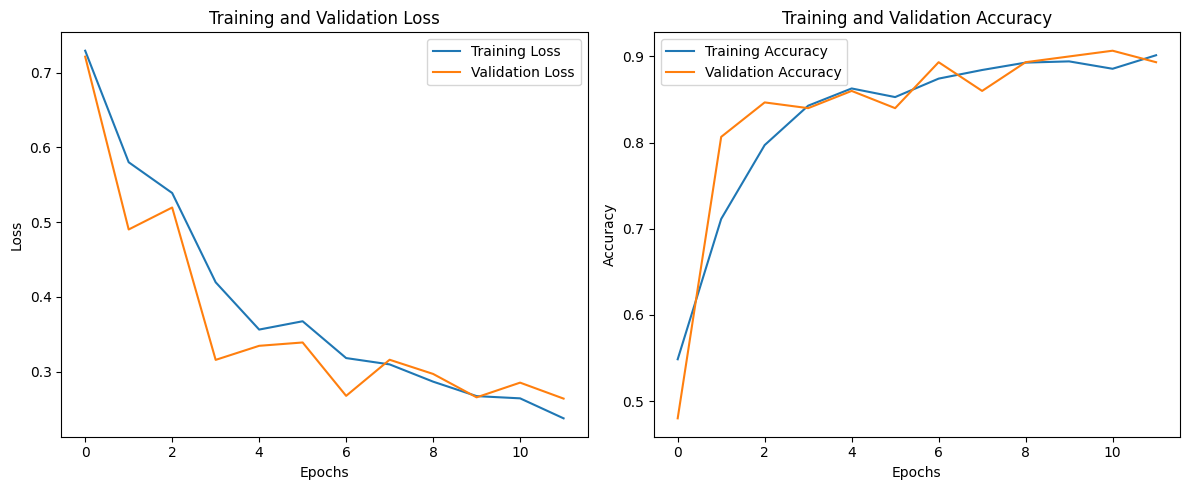

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


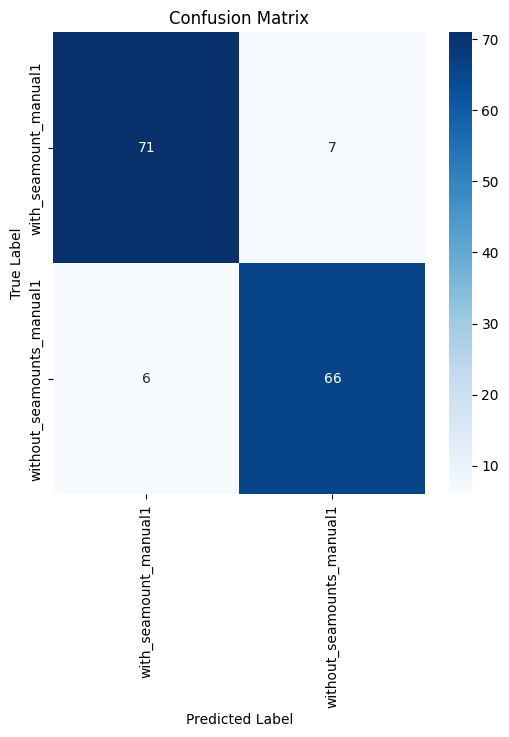

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


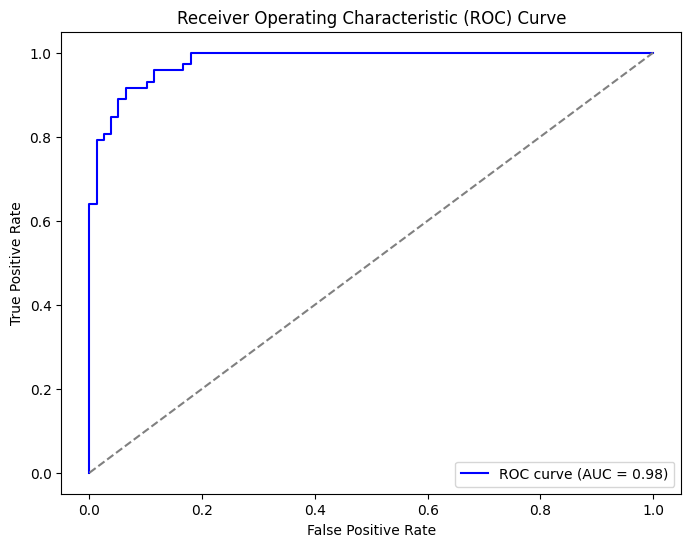

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Classification Report:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.92      0.91      0.92        78
without_seamounts_manual1       0.90      0.92      0.91        72

                 accuracy                           0.91       150
                macro avg       0.91      0.91      0.91       150
             weighted avg       0.91      0.91      0.91       150

Precision: 0.90
Recall: 0.92
F1 Score: 0.91


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting the training/validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test).flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## Show some details about the non-matches

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

--------------------------------------------------------------------------
Found 6 False Positive images - Displaying all
Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)


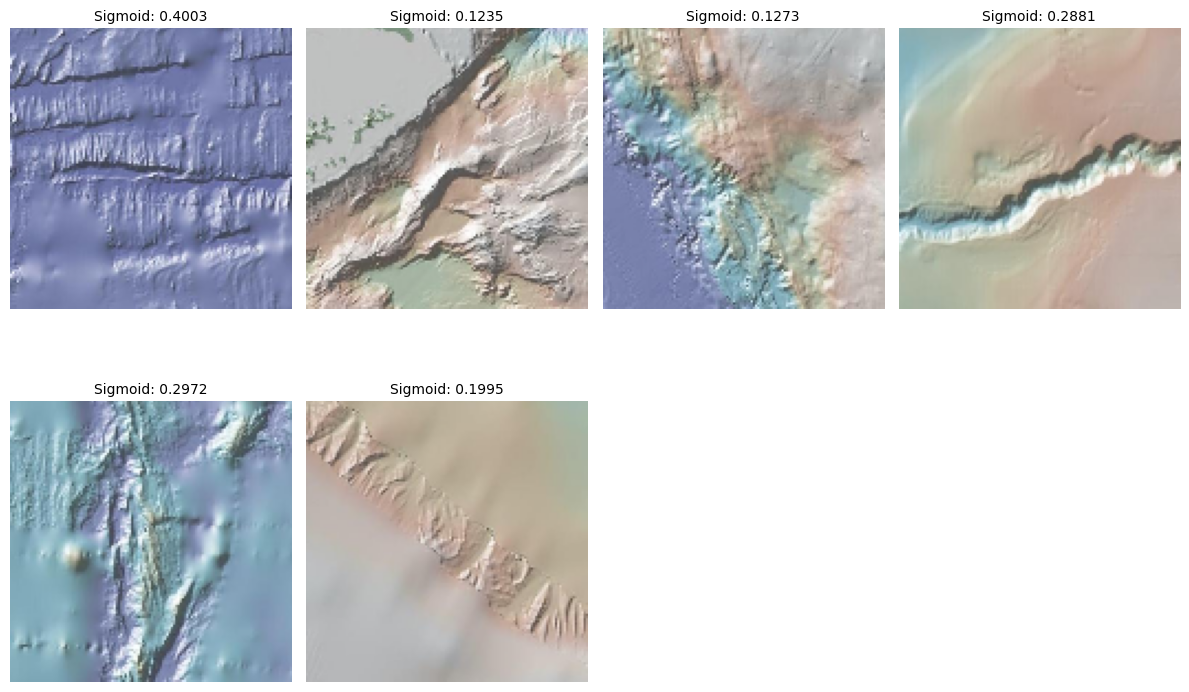


--------------------------------------------------------------------------
Found 7 False Negative images - Displaying all
Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)


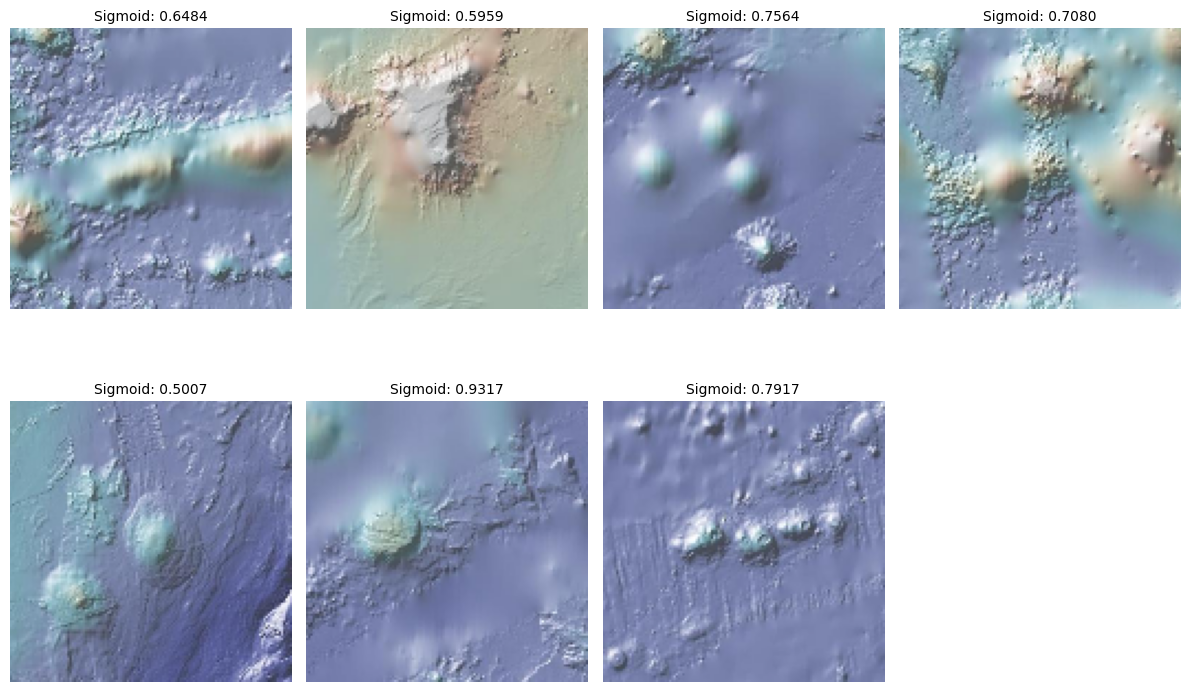

In [20]:
import matplotlib.pyplot as plt
import cv2
import math

# Get the indices of false positives and false negatives
false_positives = []
false_negatives = []

# calculate all predictions but keep sigmoid output value
y_pred_probs = model.predict(X_test).flatten() 

# Loop through the test set to find false positives and false negatives
for i in range(len(y_test)):
    
    if y_pred[i] == 0 and y_test[i] == 1:
        # Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)  
        false_positives.append(i)
    elif y_pred[i] == 1 and y_test[i] == 0: 
        # Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative) 
        false_negatives.append(i)


# Display all False Positive images in a grid of 4 columns
num_images = len(false_positives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"\n--------------------------------------------------------------------------")
print(f"Found {num_images} False Positive images - Displaying all")
print(f"Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)")

plt.figure(figsize=(columns * 3, rows * 4))  # Adjust figure size for better visualization

for i, index in enumerate(false_positives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

    # display more information to help interprete the image
    sigmoid_value =  y_pred_probs[index]
    #image_name = filenames_test[index]
    plt.title(f"Sigmoid: {sigmoid_value:.4f}", fontsize=10, pad=5) 

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Display all False Negative images in a grid of 4 columns
num_images = len(false_negatives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"\n--------------------------------------------------------------------------")
print(f"Found {num_images} False Negative images - Displaying all")
print(f"Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)")

plt.figure(figsize=(columns * 3, rows * 4))  # Adjust figure size for better visualization

for i, index in enumerate(false_negatives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

    # display more information to help interprete the image
    sigmoid_value =  y_pred_probs[index]
    #image_name = filenames_test[index]
    plt.title(f"Sigmoid: {sigmoid_value:.4f}", fontsize=10, pad=5)

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()